In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
%%writefile marketEnv.py

import gym
import numpy as np
import pandas as pd

class marketEnv(gym.Env):
    def __init__(self, data):
        self._data = pd.DataFrame.dropna(data)
        self._dates = iter(self._data.index)
        self._current_date = next(self._dates)
    
    def get_current_date(self):
        return self._current_date
    
    def reset(self):
        self.__init__(self._data)
        return self.render()
    
    def render(self):
        return(self._data.loc[[self._current_date]])

Overwriting marketEnv.py


In [20]:
%%writefile Portfolio.py

import gym
import numpy as np
import pandas as pd
import math 
from IPython.core.debugger import set_trace



class PortfolioEnv(gym.Env):
    def __init__(self, data, money = 1e+7, transaction_cost_pct=0.008, target="EURUSD"):
        """
        Here you can get data from financial market and then you can 
        create your market environment
        """
        self._kwargs = locals()
        #set_trace()
        self._data = pd.DataFrame.dropna(data)                        # data table
        self._target = target
        self._current_action = 0                 # the last action were done
        self._transaction_cost_pct = transaction_cost_pct      # transaction costs percentage 
        self._portfolio_value = money            # initial portfolio value
        self._money = money
        self._position_size = 1000000              # size of position; if positon is 0 then position_size = 0 
        
        data_pct_change = self._data.pct_change()
        state_space = pd.DataFrame.dropna(pd.concat([data_pct_change.shift(i) 
                            for i in range(9)], axis=1)).shift(0)
        roll = state_space.rolling(96)
        self._state_time_series = pd.DataFrame.dropna(
            (state_space - roll.mean()) / roll.std())
        
        self._dates = iter(self._state_time_series.index)      # dates 
        self._current_date = next(self._dates)    # current date
        self.state_shape = 6 + self._state_time_series.shape[1]
    
    def get_current_date(self):
        return self._current_date
    
    def get_current_portfolio_value(self):
        return self._portfolio_value
    
    def reset(self):
        self._dates = iter(self._state_time_series.index)      # dates 
        self._current_date = next(self._dates)    # current date
        self._portfolio_value = self._money
        self._current_action = 0 
        return self.render()
    
    def step(self, new_action=0, former_state=None):
        
        is_expl = former_state is None
        if is_expl:
            former_state = self.render()
            try:
                self._current_date = next(self._dates)
            except StopIteration:
                print("StopIteration occurred!")
                self.__init__(**self._kwargs)
        
        d = self._position_size * abs(self._current_action - new_action) * self._transaction_cost_pct
        former_portfolio_value = self._portfolio_value
        
        new_portfolio_value = self._portfolio_value + new_action * self._position_size * \
                                 (self._data[[self._target]].diff().loc[self._current_date]) - d
        
        reward = np.log(new_portfolio_value / former_portfolio_value)
        
        if is_expl:
            self._portfolio_value = new_portfolio_value
            self._current_action = new_action

        return (self.render(), float(reward), False, former_state)
    
    def get_time_feature(self):
        date = self._current_date
        return np.sin(2 * math.pi * np.array([
            date.weekday() / 6, date.hour / 23, date.minute / 45]))
    
    def to_one_hot(self, action):
        one_hot = {-1: [1, 0, 0], 0: [0, 1, 0], 1:[0, 0, 1]}
        return(np.array(one_hot[action]))
    
        
    def render_(self):
        return(np.array(pd.concat([self._state_time_series.loc[[self._current_date]], 
                             pd.DataFrame({'action': self._current_action}, index=[self._current_date])], axis=1)))[0]
                            
    def render(self, action=None):
        
        if action == None:
            action = self._current_action
        
        return np.concatenate((self.get_time_feature(), 
                         np.array(self._state_time_series.loc[self._current_date]), 
                       self.to_one_hot(action)))
    
        

Overwriting Portfolio.py


In [18]:
import pandas as pd
data = pd.DataFrame.from_csv("data/ohlc/full_table.csv")

/home/dkazanchyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [20]:
import Portfolio

from importlib import reload

reload(Portfolio)

env = Portfolio.PortfolioEnv(data, transaction_cost_pct=0.008)
state_dim = (env.state_shape, )
n_actions = 3
state = env.reset()

In [24]:
%%writefile buffer.py

import numpy as np

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        self._storage.append(data)
        if (self.__len__() > self._maxsize):
            del self._storage[0]
            
    def sample_sequence(self, sequence_size=96, batch_size=96):
        idxes = np.random.choice(range(self.__len__()), size=batch_size, replace=True)
        idx = np.random.choice(range(self.__len__() - batch_size + 1))
        idxes = np.arange(idx, idx + batch_size)
        
        # collect <s,a,r,s',done> for each index
        obs_batch = [self._storage[i][0] for i in idxes]
        act_batch = [self._storage[i][1] for i in idxes]
        rew_batch = [self._storage[i][2] for i in idxes]
        next_obs  = [self._storage[i][3] for i in idxes]
        done_mask = [self._storage[i][4] for i in idxes]
        
        return np.array(obs_batch), np.array(act_batch), np.array(rew_batch), \
               np.array(next_obs), np.array(done_mask)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = np.random.choice(range(self.__len__()), size=batch_size, replace=True)
        
        # collect <s,a,r,s',done> for each index
        obs_batch = [self._storage[i][0] for i in idxes]
        act_batch = [self._storage[i][1] for i in idxes]
        rew_batch = [self._storage[i][2] for i in idxes]
        next_obs  = [self._storage[i][3] for i in idxes]
        done_mask = [self._storage[i][4] for i in idxes]
        
        return np.array(obs_batch), np.array(act_batch), np.array(rew_batch), \
               np.array(next_obs), np.array(done_mask)


Overwriting buffer.py


In [26]:
%%writefile DQNAgent.py

from IPython.core.debugger import set_trace
from torch import nn
import torch
from torch.distributions.normal import Normal
import numpy as np
import re

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0, device=torch.device('cuda')):

        super().__init__()
        self.device=device
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        
        self.nn = nn.Sequential()
        self.nn.add_module('layer1', nn.Linear(state_shape[0], 64))
        self.nn.add_module('relu1', nn.ELU())
        self.nn.add_module('dropout1', nn.Dropout(0.2))
        
        self.nn.add_module('layer2', nn.Linear(64, 64))
        self.nn.add_module('relu2', nn.ELU())
        self.nn.add_module('dropout2', nn.Dropout(0.4))
        
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.output = nn.Sequential(nn.Linear(64, 3), nn.ELU())
        
        self.init_weights()
        
        self.hidden = torch.zeros(64, device=device)
        self.cell_state = torch.zeros(64, device=device)
        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        input_to_lstm = self.nn(torch.tensor(state_t))
        
        hiddens, state_states = self.lstm(input_to_lstm[None, :, :])
        
        qvalues = self.output(hiddens[0])

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)
    
    
    def update_weights(self, agent_weights, lr=0.0001):
        """
        This method update weights of target_network with another agent
        via formula: Q'(s, t) = Q'(s, t) + lr * Q(s, t), 
        where Q' - target network, 
        Q - agent
        
        Params:
        agent: agent network
        lr: learning rate
        """
        
        target_weights = self.state_dict()
        new_weights = {}
        
        for key in target_weights:
            new_weights[key] = (1 - lr) * target_weights[key] + lr * agent_weights[key]
            
        self.load_state_dict(new_weights)
        
    def init_weights(self):
        """
        This method initialize weights
        """
        weights = self.state_dict()
        for key, value in weights.items():
            split_key = re.split("_|\.", key)
            if 'bias' in split_key:
                if ('hh' in split_key):
                    weights[key] = torch.ones(value.size())
                else:
                    weights[key] = torch.zeros(value.size())
            elif "output" in split_key:
                weights[key] = Normal(loc=0, scale=0.001).sample(weights[key].size())
            else:
                weights[key] = torch.eye(weights[key].size()[0], weights[key].size()[1])
                
        self.load_state_dict(weights)
            
    
        

Overwriting DQNAgent.py


In [15]:
import os
import re

def from_file_to_ohlc(file):
    data = pd.read_csv("data/tick/" + file, 
                   header=None, 
                   names=["Symbol", "Date_time", "Ask", "Bid"])
    
    data.index = pd.to_datetime(data["Date_time"], format="%Y%m%d %H:%M:%S.%f")
    data_ohlc = data["Ask"].resample("15Min").ohlc()
    return data_ohlc



tickers = np.unique([file_name[: 6] for file_name in os.listdir('data/tick')])

for ticker in tickers:
    pattern = re.compile(ticker + '*')
    files = list(filter(pattern.search, os.listdir("data/tick")))
    data = pd.concat([from_file_to_ohlc(file) for file in np.sort(files)])
    pd.DataFrame.to_csv(data, 'data/ohlc/' + ticker + '.csv')

NameError: name 'np' is not defined

In [94]:
import numpy as np
import os
import re


def from_file_to_tick_volume(file):
    data = pd.read_csv("data/tick/" + file, 
                   header=None, 
                   names=["Symbol", "Date_time", "Ask", "Bid"])
    
    data.index = pd.to_datetime(data["Date_time"], format="%Y%m%d %H:%M:%S.%f")
    data_ohlc = data["Ask"].resample("15Min").count()
    return data_ohlc



tickers = np.unique([file_name[: 6] for file_name in os.listdir('data/tick')])

for ticker in tickers:
    pattern = re.compile(ticker + '*')
    files = list(filter(pattern.search, os.listdir("data/tick")))
    data = pd.concat([from_file_to_ohlc(file) for file in np.sort(files)])
    pd.DataFrame.to_csv(data, 'data/tick_volume/' + ticker + '.csv')

KeyboardInterrupt: 

In [93]:
os.listdir("data")

['tick', 'ohlc', 'sec', 'archive', 'tick_volume']

In [36]:
for file in os.listdir("data/ohlc"):
    data = pd.DataFrame.from_csv("data/ohlc/" + file)
    data = data.groupby(level=0).first()
    pd.DataFrame.to_csv(data, 'data/ohlc/' + file)

/home/dkazanchyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [258]:
from functools import reduce
data = reduce(lambda left,right: left.join(right, lsuffix='l'), 
     [ pd.DataFrame.from_csv("data/ohlc/" + ticker + '.csv')[['close']] for ticker in tickers])


data.columns = tickers
pd.DataFrame.to_csv(data, 'data/ohlc/full_table.csv')

/home/dkazanchyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
import pandas as pd

data = pd.DataFrame.from_csv("data/ohlc/AUDNZD.csv")
data.groupby(level=0).first()["2009-05-31"]

/home/dkazanchyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


,open,high,low,close
Date_time,,,,
2009-05-31 00:00:00,NaN,NaN,NaN,NaN
2009-05-31 00:15:00,NaN,NaN,NaN,NaN
2009-05-31 00:30:00,NaN,NaN,NaN,NaN
2009-05-31 00:45:00,NaN,NaN,NaN,NaN
2009-05-31 01:00:00,NaN,NaN,NaN,NaN
2009-05-31 01:15:00,NaN,NaN,NaN,NaN
2009-05-31 01:30:00,NaN,NaN,NaN,NaN
2009-05-31 01:45:00,NaN,NaN,NaN,NaN
2009-05-31 02:00:00,NaN,NaN,NaN,NaN


In [33]:
os.listdir("data/tick")


['USDJPY-2011-04.csv',
 'NZDUSD-2009-05.csv',
 'EURUSD-2014-01.csv',
 'USDJPY-2014-01.csv',
 'EURUSD-2009-09.csv',
 'AUDJPY-2014-04.csv',
 'USDCAD-2011-06.csv',
 'GBPUSD-2011-01.csv',
 'AUDUSD-2013-12.csv',
 'GBPUSD-2010-09.csv',
 'EURJPY-2012-05.csv',
 'EURJPY-2010-10.csv',
 'EURGBP-2016-03.csv',
 'GBPJPY-2013-10.csv',
 'USDJPY-2013-09.csv',
 'AUDUSD-2015-05.csv',
 'EURGBP-2009-10.csv',
 'EURJPY-2016-02.csv',
 'EURGBP-2015-07.csv',
 'EURJPY-2015-09.csv',
 'GBPJPY-2011-08.csv',
 'EURJPY-2011-10.csv',
 'AUDJPY-2016-02.csv',
 'EURCHF-2010-10.csv',
 'EURJPY-2013-12.csv',
 'AUDNZD-2012-02.csv',
 'AUDUSD-2011-04.csv',
 'EURJPY-2016-07.csv',
 'EURCHF-2012-06.csv',
 'AUDUSD-2012-05.csv',
 'AUDJPY-2010-06.csv',
 'AUDUSD-2013-04.csv',
 'AUDUSD-2012-06.csv',
 'EURUSD-2011-04.csv',
 'AUDNZD-2010-11.csv',
 'USDCAD-2012-02.csv',
 'AUDNZD-2012-03.csv',
 'EURJPY-2009-08.csv',
 'EURGBP-2014-09.csv',
 'EURGBP-2009-09.csv',
 'EURJPY-2010-03.csv',
 'CHFJPY-2013-12.csv',
 'USDCAD-2011-12.csv',
 'USDCAD-20

In [37]:
file = "EURGBP-2016-03.csv"
data = pd.read_csv("data/tick/" + file, 
               header=None, 
               names=["Symbol", "Date_time", "Ask", "Bid"])

data.index = pd.to_datetime(data["Date_time"], format="%Y%m%d %H:%M:%S.%f")
data_ohlc = data["Bid"].resample("15Min").count()


<function matplotlib.pyplot.show(*args, **kw)>

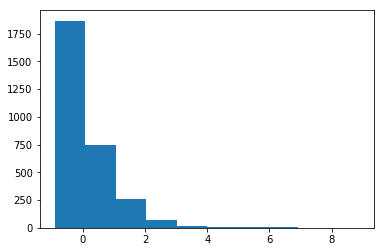

In [43]:
import matplotlib.pyplot as plt
plt.hist((data_ohlc - data_ohlc.mean()) / data_ohlc.std())
plt.show

In [52]:
data = pd.read_csv("data/tick/" + "AUDNZD-2009-05.csv", 
           header=None, 
           names=["Symbol", "Date_time", "Ask", "Bid"])

data.index = pd.to_datetime(data["Date_time"], format="%Y%m%d %H:%M:%S.%f")
data_ohlc = data["Ask"].resample("15Min").ohlc()
data_ohlc['tick_value'] = data["Ask"].resample("15Min").count()

In [29]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('data', 34401816),
 ('state', 1224),
 ('from_file_to_ohlc', 136),
 ('reload', 136),
 ('pd', 80),
 ('env', 56),
 ('state_dim', 56),
 ('n_actions', 28)]